# Morningstar Due Diligence Report

This report aims to analyze Morningstar's financials, predict EPS ahead of Q2 earnings and place a directional trade based on findings.

The following analysis utilizes python to achieve:

* Competitive analysis and correlation of stock prices using OpenBB SDK

* Income statement comparison using OpenBB SDK

* Predict upcoming EPS using Facebook Prophet 

* Right pricing call options using a Black Scholes model

In [1]:
from openbb_terminal.sdk import openbb
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly
%matplotlib inline
from datetime import datetime
import QuantLib as ql

## Competitive Analysis 

Using Tradingview's Markets tool I discovered a handful of competitor's to Morningstar in the Investent Managers sector. Each competitor is in the ballpark of Morningstars $8.6B market cap. Essentially exclusing Blackrock and Blackstone from the mix. 

First, using OpenBB's Comparison Analysis module I ran historical stock price correlation to see which competitors have the strongest corellation in stock price to Morningstar. 

In [2]:
correlation,historical = (
    openbb.stocks.ca.hcorr(['MORN','CG','PFG','TROW','UBS','RJF','BAM','IVZ'],
    candle_type = 'R',
    start_date = '2018-01-01'
    )
)
correlation


NaN values found in: MORN, CG, PFG, TROW, UBS, RJF, BAM, IVZ.  Backfilling data

,MORN,CG,PFG,TROW,UBS,RJF,BAM,IVZ
MORN,1.000000,0.480391,0.391442,0.526764,0.403970,0.411396,0.091422,0.412525
CG,0.480391,1.000000,0.591526,0.637430,0.592712,0.573145,0.076955,0.582789
PFG,0.391442,0.591526,1.000000,0.660593,0.697331,0.765170,0.087766,0.719056
TROW,0.526764,0.637430,0.660593,1.000000,0.629401,0.690101,0.076464,0.724619
UBS,0.403970,0.592712,0.697331,0.629401,1.000000,0.674700,0.068192,0.667697
RJF,0.411396,0.573145,0.765170,0.690101,0.674700,1.000000,0.082481,0.708065
BAM,0.091422,0.076955,0.087766,0.076464,0.068192,0.082481,1.000000,0.059432
IVZ,0.412525,0.582789,0.719056,0.724619,0.667697,0.708065,0.059432,1.000000


Finding Carlyle Group and T.Rowe Price had the strongest correlation, I compiled them with Morningstar into a list object to further compare the three companies. 

Using OpenBB.ca I pulled the latest quarterly income statements for each company. 

Morningstar’s ($7.6M) net income compared to the + $100M from both Carlyle and T.Rowe breaks from the stock price correlation to show a unique loss for Morningstar and not a bearish investment management sector. 


In [30]:
symbols = ['MORN','CG','TROW']

income = openbb.stocks.ca.income(symbols, timeframe = ("31-Mar-2023"), quarter = True)

income.tail(20)

Other available quarterly timeframes are: 31-Mar-2022, 30-Jun-2022, 30-Sep-2022, 31-Dec-2022, 31-Mar-2023

31-Mar-2023                 
                                                 MORN       CG    TROW
Item                                                                  
Minority Interest Expense                           -    24.6M   20.2M
Net Income                                     (7.6M)   100.7M    411M
Net Income Growth                            -330.30%  -20.83%  58.38%
Net Margin Growth                              -1.55%   14.38%  26.73%
Extraordinaries & Discontinued Operations           -        -       -
Extra Items & Gain/Loss Sale Of Assets              -        -       -
Cumulative Effect - Accounting Chg                  -        -       -
Discontinued Operations                             -        -       -
Net Income After Extraordinaries               (7.6M)   100.7M    411M
Preferred Dividends                                 -        -       -
Net Income Available to Common                 (7.6M)   100.7M    411M
EPS (Basic)                                    (0.18)     0.28    1.83
EPS (Basic) Growth                           -330.41%  -20.81%  57.90%
Basic Shares Outstanding                        42.5M  362.94M  224.4M
EPS (Diluted)                                  (0.18)     0.28    1.83
EPS (Diluted) Growth                         -331.31%  -20.58%  57.95%
Diluted Shares Outstanding                      42.5M  365.36M  225.2M
EBITDA                                          88.7M      NaN     NaN
EBITDA Growth                                  -8.27%      NaN     NaN
EBITDA Margin                                  18.12%      NaN     NaN

I went to Morningstar’s Q1 23’ earnings presentation to look deeper into financials. Adjusted operating margin since Q1 21’ has been in a steady decline and likely reflects why Q1 23’ resulted in a net income loss. 

Below I manually pulled adjusted operating income from Q1 21’ - Q1 23’ into a dictionary and converted it into a dataframe to plot the decline in margin. 


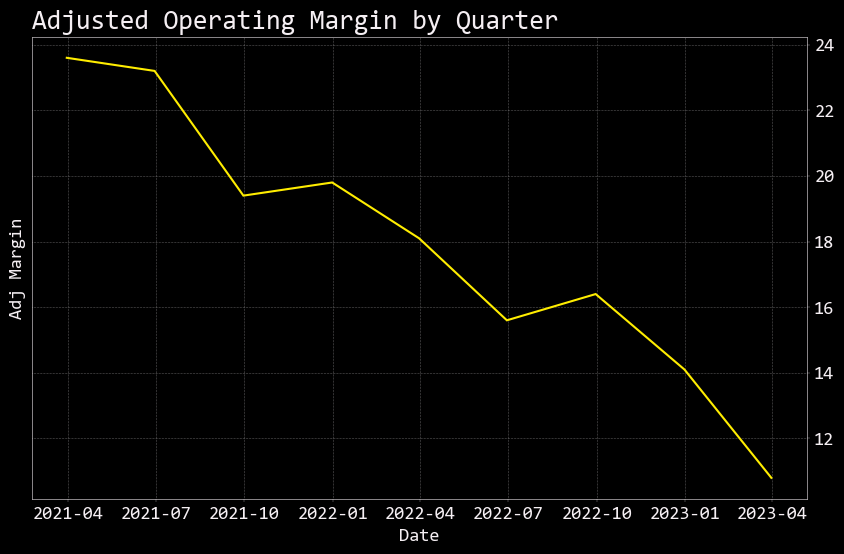

In [37]:
adj_margin = {
    'Date': ['2021-03-31','2021-06-30','2021-09-30','2021-12-31','2022-03-31','2022-06-30','2022-09-30','2022-12-31','2023-03-31'],
    'Adj Margin': [23.6, 23.2, 19.4, 19.8, 18.1, 15.6, 16.4, 14.1, 10.8]
}

adj_margin = pd.DataFrame(adj_margin)
adj_margin['Date'] = pd.to_datetime(adj_margin['Date'])

plt.figure(figsize=(10,6))
plt.plot(adj_margin['Date'], adj_margin['Adj Margin'])
plt.title('Adjusted Operating Margin by Quarter')
plt.xlabel('Date')
plt.ylabel('Adj Margin')
plt.grid(True)
plt.show()

To predict Morningstar EPS for the upcoming Q2 earnings, I pulled in a CSV file that contained quarterly EPS dating back to IPO in 2010. 

For time series analysis I used Facebook Prophet, an open source algorithm used for predicting financial outcomes. 

In this case, I’ll be looking to predict the upcoming year (4 quarters) of EPS. 


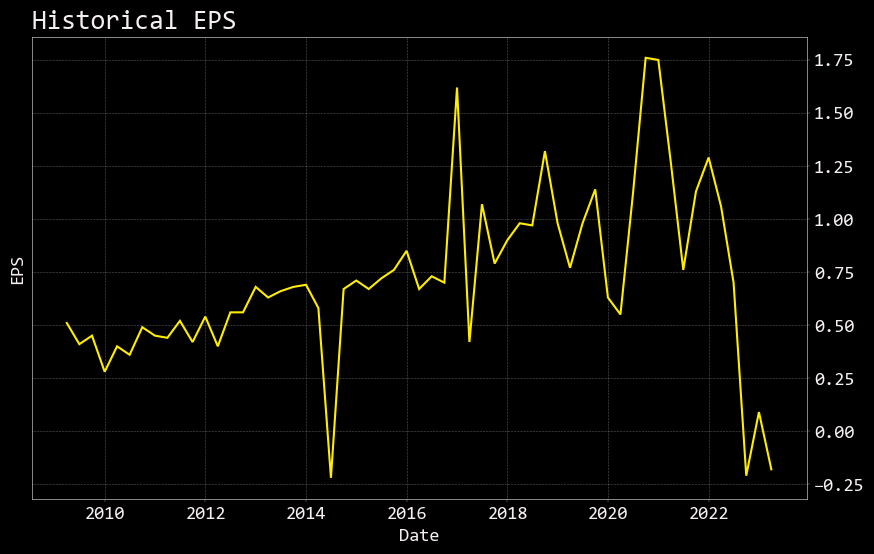

In [36]:
df = pd.read_csv("MorningstarEPS.csv")
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['EPS'])
plt.title('Historical EPS')
plt.xlabel('Date')
plt.ylabel('EPS')
plt.grid(True)
plt.show()

In [9]:
df = df.rename(columns={'Date': 'ds', 'EPS': 'y'})

df.head()

,ds,y
0,2023-03-31,-0.18
1,2022-12-31,0.09
2,2022-09-30,-0.21
3,2022-06-30,0.70
4,2022-03-31,1.06


In [10]:
my_model = Prophet(interval_width=0.95)

my_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=4, freq= 'Q', include_history= True)
future_dates.tail()

09:19:38 - cmdstanpy - INFO - Chain [1] start processing
09:19:39 - cmdstanpy - INFO - Chain [1] done processing


,ds
56,2023-03-31
57,2023-06-30
58,2023-09-30
59,2023-12-31
60,2024-03-31


Below we arrive at the predicted EPS values (yhat), the bearish predicted value (yhat_lower) and bullish predicted value (yhat_upper) for the 4 upcoming quarters. 

The FB Prophet model predicted .86 for the upcoming Q2 results. Assuming no change in outstanding shares that would require nearly $42M difference in net income quarter over quarter. Even the bearish (yhat_lower) at .22 EPS is a nearly $16M difference. 

If I act as a Wallstreet Analyst, I could say the bearish Q2 EPS at .22 is our consensus projections for Morningstar.

If I act as a Wallstreet speculator, I’d say the .22 EPS projection is a little high given the downtrend in adjusted operating margin over the last few years. 

As a Wallstreet speculator, I would be bearish heading into Q2 earnings and look for a short position on expected earnings miss.


In [12]:
forecast = my_model.predict(future_dates)
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper',]]

forecast_df['Load_Date'] = datetime.now()

forecast_df.tail(4)

/var/folders/7n/qqbwqb3s2r147wkkm33_p6sw0000gn/T/ipykernel_10817/2664705872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['Load_Date'] = datetime.now()


,ds,yhat,yhat_lower,yhat_upper,Load_Date
57,2023-06-30,0.868615,0.224003,1.613459,2023-06-08 09:20:17.725673
58,2023-09-30,0.898620,0.218704,1.511204,2023-06-08 09:20:17.725673
59,2023-12-31,0.762445,0.098359,1.441510,2023-06-08 09:20:17.725673
60,2024-03-31,0.977826,0.332003,1.663475,2023-06-08 09:20:17.725673


As a bonus piece to this, the following code writes these predictions back to a table in Snowflake to be utilized in the database.

In [ ]:
def write_to_snowflake(df, table_name, write_mode = 'append'):  
    spark.conf.set("spark.sql.execution.arrow.enabled", "true") 
    
    sp_df_update = spark.createDataFrame(df) 

    options = dict(sfUrl="https://ws67899.east-us-2.azure.snowflakecomputing.com",
                   sfUser=user, 
                   sfPassword=password, 
                   usestagingtable="off", 
                   sfDatabase="SANDBOX", 
                   sfSchema="MEDIA", 
                   sfWarehouse="DATALOADUNLOAD_WH",) 
    sp_df_update.write.format("snowflake").options(**options).option("dbtable", table_name).mode(write_mode).save()

If I’m bearish on Morningstar heading into Q2 earnings, the candle chart helps to show how Wallstreet has also been very bearish on the last two Morningstar earnings. 

Looking at the candle chart, there are large red candle sticks for price and volume on the last two quarterly earning days. Q4 22’ saw (8%) drawdown and Q1 23’ (12%) hitting a pandemic level low. 

The reaction on Wallstreet to Morningstar earnings shows clear bearish movement on poor earnings. I’m speculating another EPS miss in Q2 23’ so we’ll look to find a bearish position heading into earnings. 

Loading Daily data for MORN with starting period 2020-06-03.

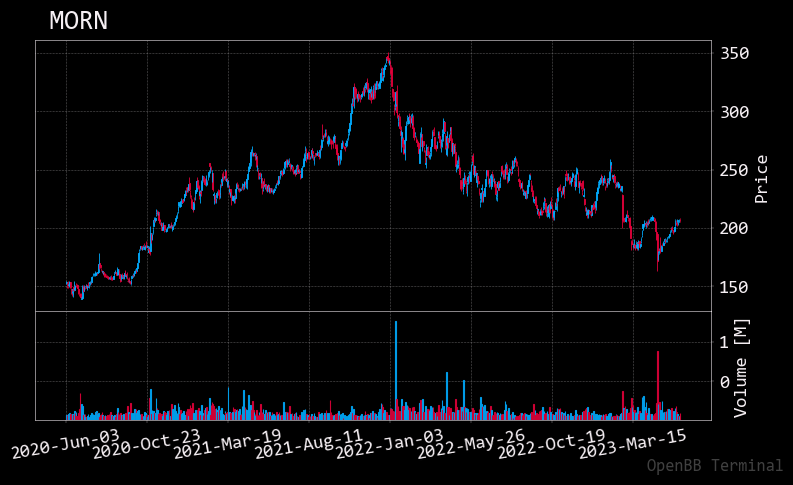

In [31]:
openbb.stocks.candle('MORN')

Disclaimer: OpenBB isn’t returning complete options chain data for the Sept 15th expiration date. For the sake of exercise I’ll keep the code here, but will use MORN Sept 15th options chain data from TD Ameritrade ThinkorSwim trading platform. 

Being bearish heading into earnings, I will look to buy a put option right under the current MORN price of $204. 

The $200 strike price on 9/15 Puts has a bid price of $6.60 and an ask price of $10.50 

In [48]:
morn_chain = openbb.stocks.options.chains(symbol = 'MORN')
pd.set_option('display.max_rows',None)
morn_chain = morn_chain[(morn_chain['expirygroup'] == 'September 15, 2023')]

morn_chain.head(100)

,expirygroup,expiryDate,c_Last,c_Change,c_Bid,c_Ask,c_Volume,c_Openinterest,strike,p_Last,p_Change,p_Bid,p_Ask,p_Volume,p_Openinterest
71,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,90.0,0.15,0.0,0.0,0.0,0,1
72,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,95.0,0.00,0.0,0.0,0.0,0,0
73,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,100.0,0.00,0.0,0.0,0.0,0,0
74,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,105.0,0.00,0.0,0.0,0.0,0,0
75,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,110.0,0.75,0.0,0.0,0.0,0,7
76,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,115.0,0.00,0.0,0.0,0.0,0,0
77,"September 15, 2023",Sep 15,107.30,0.0,0.0,0.0,0,1,120.0,0.00,0.0,0.0,0.0,0,0
78,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,125.0,1.60,0.0,0.0,0.0,0,3
79,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,130.0,0.00,0.0,0.0,0.0,0,0
80,"September 15, 2023",Sep 15,0.00,0.0,0.0,0.0,0,0,135.0,0.00,0.0,0.0,0.0,0,0


Using the QuantLib package we will run our $200 9/15 put contract thru a Black-Scholes model to right price the options contract. The goal of using a Black-Scholes model is to find mispricings in options and exploit the gaps in actual values vs. expected value.

Below we'll initiate our option contract data into the Black-Scholes model. 

In [60]:
# Define option data to load into the model
maturity_date = ql.Date(15,9,2023)
spot_price = 204.79
strike_price = 200
iv = .2998
dividend_rate = 0.0
option_type = ql.Option.Put 

risk_free_rate = 0.001
day_count=ql.Actual365Fixed()
calendar = ql.NullCalendar()

calculation_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = calculation_date

payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date 

am_exercise = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)

In [61]:
#Prep the Black_Scholes varibles for loading into BlackScholesMertonProcess

spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))

flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,risk_free_rate,day_count))

divident_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date,dividend_rate,day_count))

flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date,calendar,iv,day_count))

bsm_process = ql.BlackScholesMertonProcess(spot_handle,flat_ts,divident_yield,flat_vol_ts)


The final step in the Black-Scholes model will produce the expected value of the option contract. 

morn_EV produced an expected value of $10.29 for the $200 9/15 put contract. 

In [63]:
#Load Black Scholes process into the pricing engine to produce an expected value of the option premium 
steps = 200
binomial_engine = ql.BinomialVanillaEngine(bsm_process,"crr",steps)
american_option.setPricingEngine(binomial_engine)

morn_EV = american_option.NPV()

print(morn_EV)

10.296120352529211


There is a fairly wide gap on the $200 9/15 put contract bid vs. asking price. 

The ask price is $10.50 and the bid price is $6.60. 

Our Black-Scholes model right-priced the contract at $10.29 so it’s right inline with the ask price. 

Given such a wide gap in bid vs. ask price, It’s likely we could win the contract in the $8-9 range. 

We’ve now set a short position on Morningstar ahead of an expected Q2 EPS miss, and we’ve exploited mispricing of the put option contract to compound anticipated gains. 
